In [1]:
import pandas as pd
import numpy as np
from faker import Faker
from datetime import datetime, timedelta
import random
import sys
import subprocess
from collections import Counter

# --- ENSURE LIBRARIES ARE INSTALLED ---
try:
    print("Ensuring required libraries are installed...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pm4py", "matplotlib", "seaborn", "networkx", "-q"])
    import pm4py
    import matplotlib.pyplot as plt
    import seaborn as sns
    import networkx as nx
    print("✅ Libraries are ready.")
except Exception as e:
    print(f"An error occurred during library installation: {e}")
    sys.exit()

from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

Ensuring required libraries are installed...
✅ Libraries are ready.


In [2]:
# Initialize Faker
fake = Faker()

# --- 1. DATA SIMULATION (WITH DELAYS) ---
def simulate_event_log(num_cases=50):
    print("\nStep 1: Simulating process event log with delays...")
    resources = { 'Exploratory': [fake.name() for _ in range(10)], 'Exploitative': [fake.name() for _ in range(10)], 'Integration': [fake.name() for _ in range(3)] }
    exploratory_activities = ['Market Research', 'Hypothesis Formulation', 'Compound Synthesis', 'Pre-clinical Testing', 'Analyze Results', 'Peer Review', 'Patent Filing', 'Handoff to Commercial']
    exploitative_activities = ['Qualify Lead', 'Send Quote', 'Negotiate Contract', 'Close Deal', 'Initiate Production', 'Quality Check', 'Ship Product']
    log_data = []
    start_time = datetime(2024, 1, 1)

    for i in range(num_cases):
        process_type = random.choice(['Exploratory', 'Exploitative'])
        current_time = start_time + timedelta(days=i*10, hours=random.randint(1,5))

        if process_type == 'Exploratory':
            case_id = f"DRUG-{100 + i}"
            activities = sorted(random.sample(exploratory_activities, k=random.randint(5, len(exploratory_activities))), key=lambda x: exploratory_activities.index(x))
            for activity in activities:
                duration = timedelta(days=random.randint(5, 20))
                # Handoff and Testing are more likely to have delays
                delay_chance = 0.6 if activity in ['Handoff to Commercial', 'Pre-clinical Testing'] else 0.2
                delay = timedelta(days=random.randint(5, 15)) if random.random() < delay_chance else timedelta(0)
                
                planned_finish = current_time + duration
                actual_finish = planned_finish + delay
                resource = random.choice(resources['Integration']) if activity == 'Handoff to Commercial' else random.choice(resources['Exploratory'])
                log_data.append([case_id, activity, current_time, actual_finish, resource, 'Exploratory', delay.total_seconds() / 3600])
                current_time = actual_finish
        else:
            case_id = f"SALE-{200 + i}"
            activities = exploitative_activities
            for activity in activities:
                duration = timedelta(days=random.randint(1, 3))
                delay = timedelta(days=random.randint(1, 2)) if random.random() < 0.15 else timedelta(0) # Less frequent delays
                planned_finish = current_time + duration
                actual_finish = planned_finish + delay
                resource = random.choice(resources['Exploitative'])
                log_data.append([case_id, activity, current_time, actual_finish, resource, 'Exploitative', delay.total_seconds() / 3600])
                current_time = actual_finish

    log_df = pd.DataFrame(log_data, columns=['case:concept:name', 'concept:name', 'time:timestamp', 'time:actual_finish', 'org:resource', 'case:type', 'delay_hours'])
    print("✅ Event log simulation complete.\n")
    return log_df

In [3]:
# --- 2. ADVANCED BOTTLENECK ANALYSIS ---
def analyze_and_visualize_bottlenecks(log_df, process_type):
    print(f"Step 2: Advanced Bottleneck Analysis for '{process_type}'...")
    proc_df = log_df[log_df['case:type'] == process_type].copy()
    
    # Total delay caused by each activity
    bottlenecks = proc_df.groupby('concept:name')['delay_hours'].sum().sort_values(ascending=False).head(10)
    
    plt.figure(figsize=(12, 8))
    colors = ['red' if i == 'Handoff to Commercial' else 'skyblue' for i in bottlenecks.index]
    ax = sns.barplot(x=bottlenecks.values, y=bottlenecks.index, palette=colors, orient='h')
    for i in ax.containers:
        ax.bar_label(i, fmt='%.0f hrs', label_type='edge', fontsize=10, padding=5)

    plt.title(f'Top Bottlenecks in {process_type} Processes (by Total System Delay Caused)', fontsize=16, fontweight='bold')
    plt.xlabel('Total Downstream Delay Caused (Hours)', fontsize=12)
    plt.ylabel('Activity', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'bottleneck_analysis_{process_type.lower()}.png')
    print(f"✅ {process_type} bottleneck analysis chart saved.\n")

In [4]:
# --- 3. VISUAL PROCESS FLOW ---
def visualize_process_flow(log_df, process_type):
    print(f"Step 3: Generating Process Flow Map for '{process_type}'...")
    proc_df = log_df[log_df['case:type'] == process_type].copy()
    transitions = Counter()
    for _, case_df in proc_df.groupby('case:concept:name'):
        activities = case_df.sort_values('time:timestamp')['concept:name'].tolist()
        for i in range(len(activities) - 1):
            transitions[(activities[i], activities[i+1])] += 1
            
    G = nx.DiGraph()
    for (act_from, act_to), count in transitions.items():
        G.add_edge(act_from, act_to, weight=count)
        
    plt.figure(figsize=(16, 16))
    pos = nx.spring_layout(G, k=1.5, iterations=50, seed=42)
    weights = [G[u][v]['weight']/2 for u,v in G.edges()]
    
    nx.draw(G, pos, with_labels=True, node_color='lightgreen', node_size=3500,
            connectionstyle='arc3,rad=0.1', edge_color='black', width=weights,
            font_size=10, font_weight='bold', arrowsize=20)
            
    plt.title(f'Visual Process Map: {process_type}', fontsize=20, fontweight='bold')
    plt.savefig(f'process_map_{process_type.lower()}.png')
    print(f"✅ {process_type} process map saved.\n")

In [5]:
# --- 4. DIFFERENTIATION ANALYSIS ---
def analyze_process_differentiation(log_df):
    print("Step 4: Projective Differentiation Analysis...")
    case_durations = log_df.groupby(['case:concept:name', 'case:type'])['time:timestamp'].agg(['min', 'max'])
    case_durations['duration_days'] = (case_durations['max'] - case_durations['min']).dt.total_seconds() / (24 * 3600)
    
    exploratory_log = log_converter.apply(log_df[log_df['case:type'] == 'Exploratory'])
    exploitative_log = log_converter.apply(log_df[log_df['case:type'] == 'Exploitative'])
    num_variants_exploratory = len(pm4py.get_variants(exploratory_log))
    num_variants_exploitative = len(pm4py.get_variants(exploitative_log))

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    sns.boxplot(x='case:type', y='duration_days', data=case_durations, ax=axes[0], palette='viridis')
    axes[0].set_title('Distribution of Process Durations', fontsize=14)
    sns.barplot(x=['Exploratory', 'Exploitative'], y=[num_variants_exploratory, num_variants_exploitative], ax=axes[1], palette='plasma')
    axes[1].set_title('Process Variability (Number of Variants)', fontsize=14)
    plt.suptitle('Detailed Process Differentiation Summary', fontsize=18, fontweight='bold')
    plt.savefig('differentiation_summary_detailed.png')
    print("✅ Detailed differentiation summary chart saved.\n")

In [6]:
# --- 5. INTEGRATION ANALYSIS ---
def analyze_process_integration(log_df):
    print("Step 5: Projective Integration Analysis (Enhanced SNA Graph)...")
    handoffs = Counter()
    for _, case_df in log_df.sort_values(['case:concept:name', 'time:timestamp']).groupby('case:concept:name'):
        resources = case_df['org:resource'].tolist()
        for i in range(len(resources) - 1):
            if resources[i] != resources[i+1]:
                handoffs[tuple(sorted((resources[i], resources[i+1])))] += 1
                
    top_10_pairs = {pair for pair, count in handoffs.most_common(10)}
    G = nx.Graph()
    for (res1, res2), count in handoffs.items():
        G.add_edge(res1, res2, weight=count)
        
    plt.figure(figsize=(18, 18))
    pos = nx.spring_layout(G, k=0.9, iterations=50, seed=42)
    nx.draw_networkx_nodes(G, pos, node_color='lightgray', node_size=1000)
    nx.draw_networkx_edges(G, pos, edge_color='lightgray', width=1)
    top_edges = [edge for edge in G.edges() if tuple(sorted(edge)) in top_10_pairs]
    top_nodes = list(set(node for edge in top_edges for node in edge))
    nx.draw_networkx_nodes(G, pos, nodelist=top_nodes, node_color='skyblue', node_size=2500, edgecolors='black')
    nx.draw_networkx_edges(G, pos, edgelist=top_edges, edge_color='black', width=4)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    plt.title('Enhanced Social Network Highlighting Top 10 Collaborations', fontsize=22, fontweight='bold')
    plt.savefig('integration_sna_graph_enhanced.png')
    print("✅ Enhanced SNA collaboration graph saved.\n")

In [7]:
# --- 6. MANAGER DASHBOARD ---
def generate_manager_process_dashboard(log_df, manager_name, team_members):
    print(f"Step 6: Generating Process Dashboard for Manager: {manager_name}...")
    team_log = log_df[log_df['org:resource'].isin(team_members)]
    if team_log.empty: return
    team_type = team_log['case:type'].mode()[0]
    active_cases = team_log['case:concept:name'].nunique()
    avg_case_duration = team_log.groupby('case:concept:name').apply(lambda x: x['time:timestamp'].max() - x['time:timestamp'].min()).mean()
    bottleneck_activity = team_log.groupby('concept:name')['delay_hours'].sum().idxmax()
    
    print("\n" + "="*60)
    print(f"MANAGER PROCESS DASHBOARD: {manager_name.upper()}")
    print("="*60)
    print(f"TEAM FOCUS (derived from process data): {team_type.upper()}")
    print("\n--- Real-Time Process KPIs ---")
    print(f"Active Cases Handled by Team: {active_cases}")
    print(f"Average Time to Complete a Case: {avg_case_duration}")
    print(f"Top Bottleneck Activity (by delay caused): '{bottleneck_activity}'")
    print("\n--- Current Resource Allocation ---")
    print(team_log['org:resource'].value_counts().to_string())
    print("="*60 + "\n")


Step 1: Simulating process event log with delays...
✅ Event log simulation complete.

Step 2: Advanced Bottleneck Analysis for 'Exploratory'...


C:\Users\radjo\AppData\Local\Temp\ipykernel_48552\3854462317.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=bottlenecks.values, y=bottlenecks.index, palette=colors, orient='h')


✅ Exploratory bottleneck analysis chart saved.

Step 2: Advanced Bottleneck Analysis for 'Exploitative'...


C:\Users\radjo\AppData\Local\Temp\ipykernel_48552\3854462317.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=bottlenecks.values, y=bottlenecks.index, palette=colors, orient='h')


✅ Exploitative bottleneck analysis chart saved.

Step 3: Generating Process Flow Map for 'Exploratory'...
✅ Exploratory process map saved.

Step 3: Generating Process Flow Map for 'Exploitative'...
✅ Exploitative process map saved.

Step 4: Projective Differentiation Analysis...


C:\Users\radjo\AppData\Local\Temp\ipykernel_48552\566504399.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='case:type', y='duration_days', data=case_durations, ax=axes[0], palette='viridis')
C:\Users\radjo\AppData\Local\Temp\ipykernel_48552\566504399.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Exploratory', 'Exploitative'], y=[num_variants_exploratory, num_variants_exploitative], ax=axes[1], palette='plasma')


✅ Detailed differentiation summary chart saved.

Step 5: Projective Integration Analysis (Enhanced SNA Graph)...
✅ Enhanced SNA collaboration graph saved.

Step 6: Generating Process Dashboard for Manager: Christopher Chambers...

MANAGER PROCESS DASHBOARD: CHRISTOPHER CHAMBERS
TEAM FOCUS (derived from process data): EXPLORATORY

--- Real-Time Process KPIs ---
Active Cases Handled by Team: 32
Average Time to Complete a Case: 15 days 01:30:00
Top Bottleneck Activity (by delay caused): 'Pre-clinical Testing'

--- Current Resource Allocation ---
org:resource
Shannon Robinson      19
Walter Flowers        12
Sarah Washington      11
Jeffrey Herrera        8
Shannon Montgomery     5

✅ Full Process Mining Analysis complete.


C:\Users\radjo\AppData\Local\Temp\ipykernel_48552\4104887909.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_case_duration = team_log.groupby('case:concept:name').apply(lambda x: x['time:timestamp'].max() - x['time:timestamp'].min()).mean()


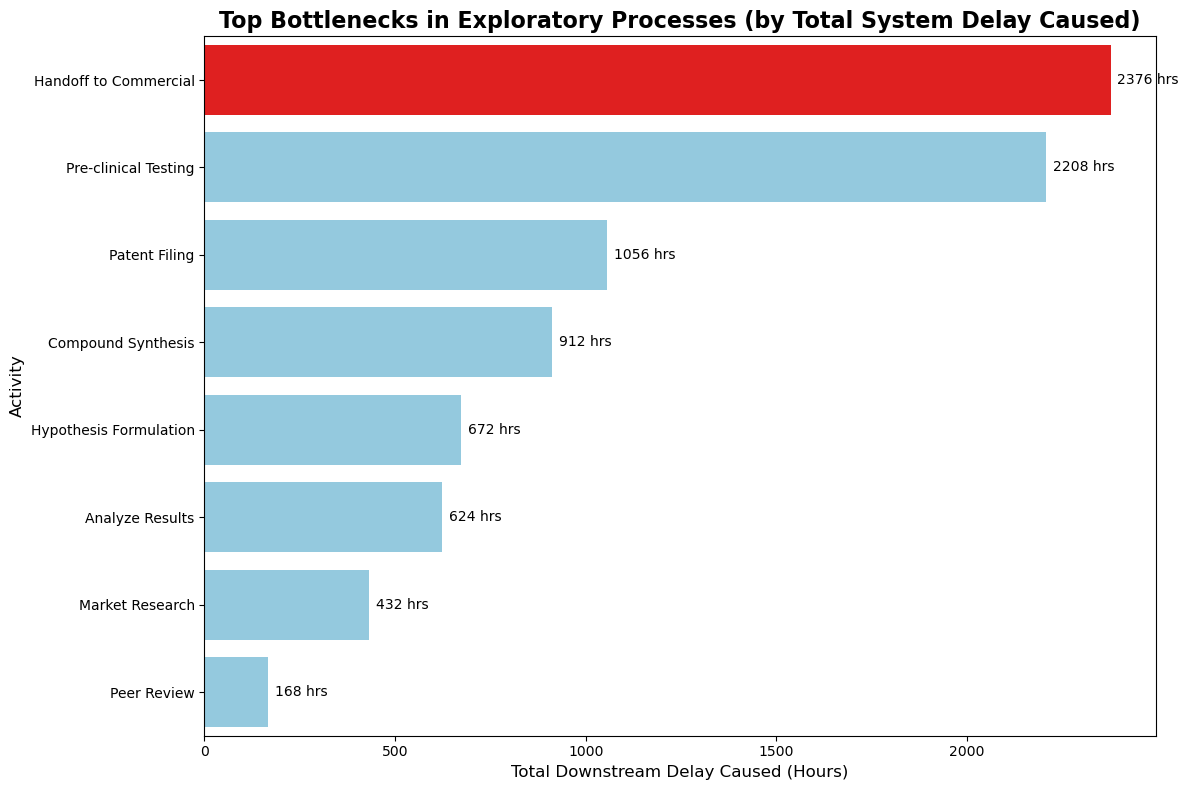

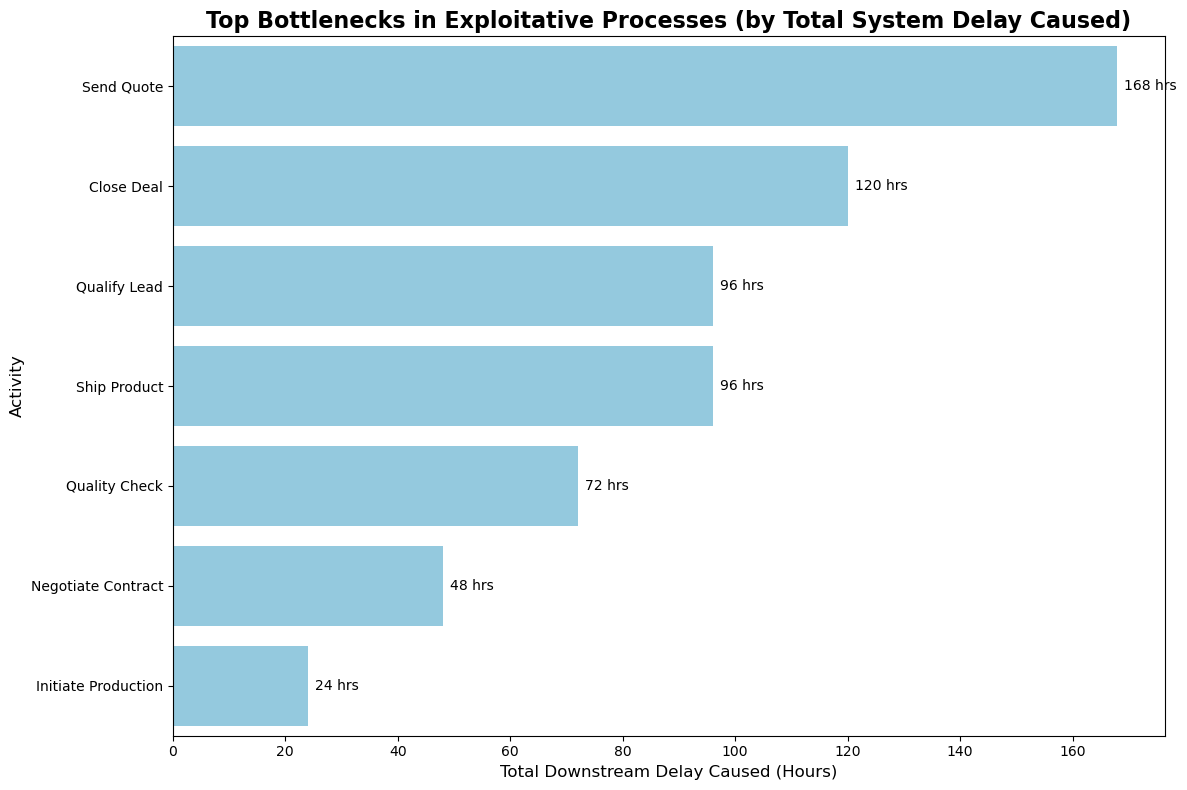

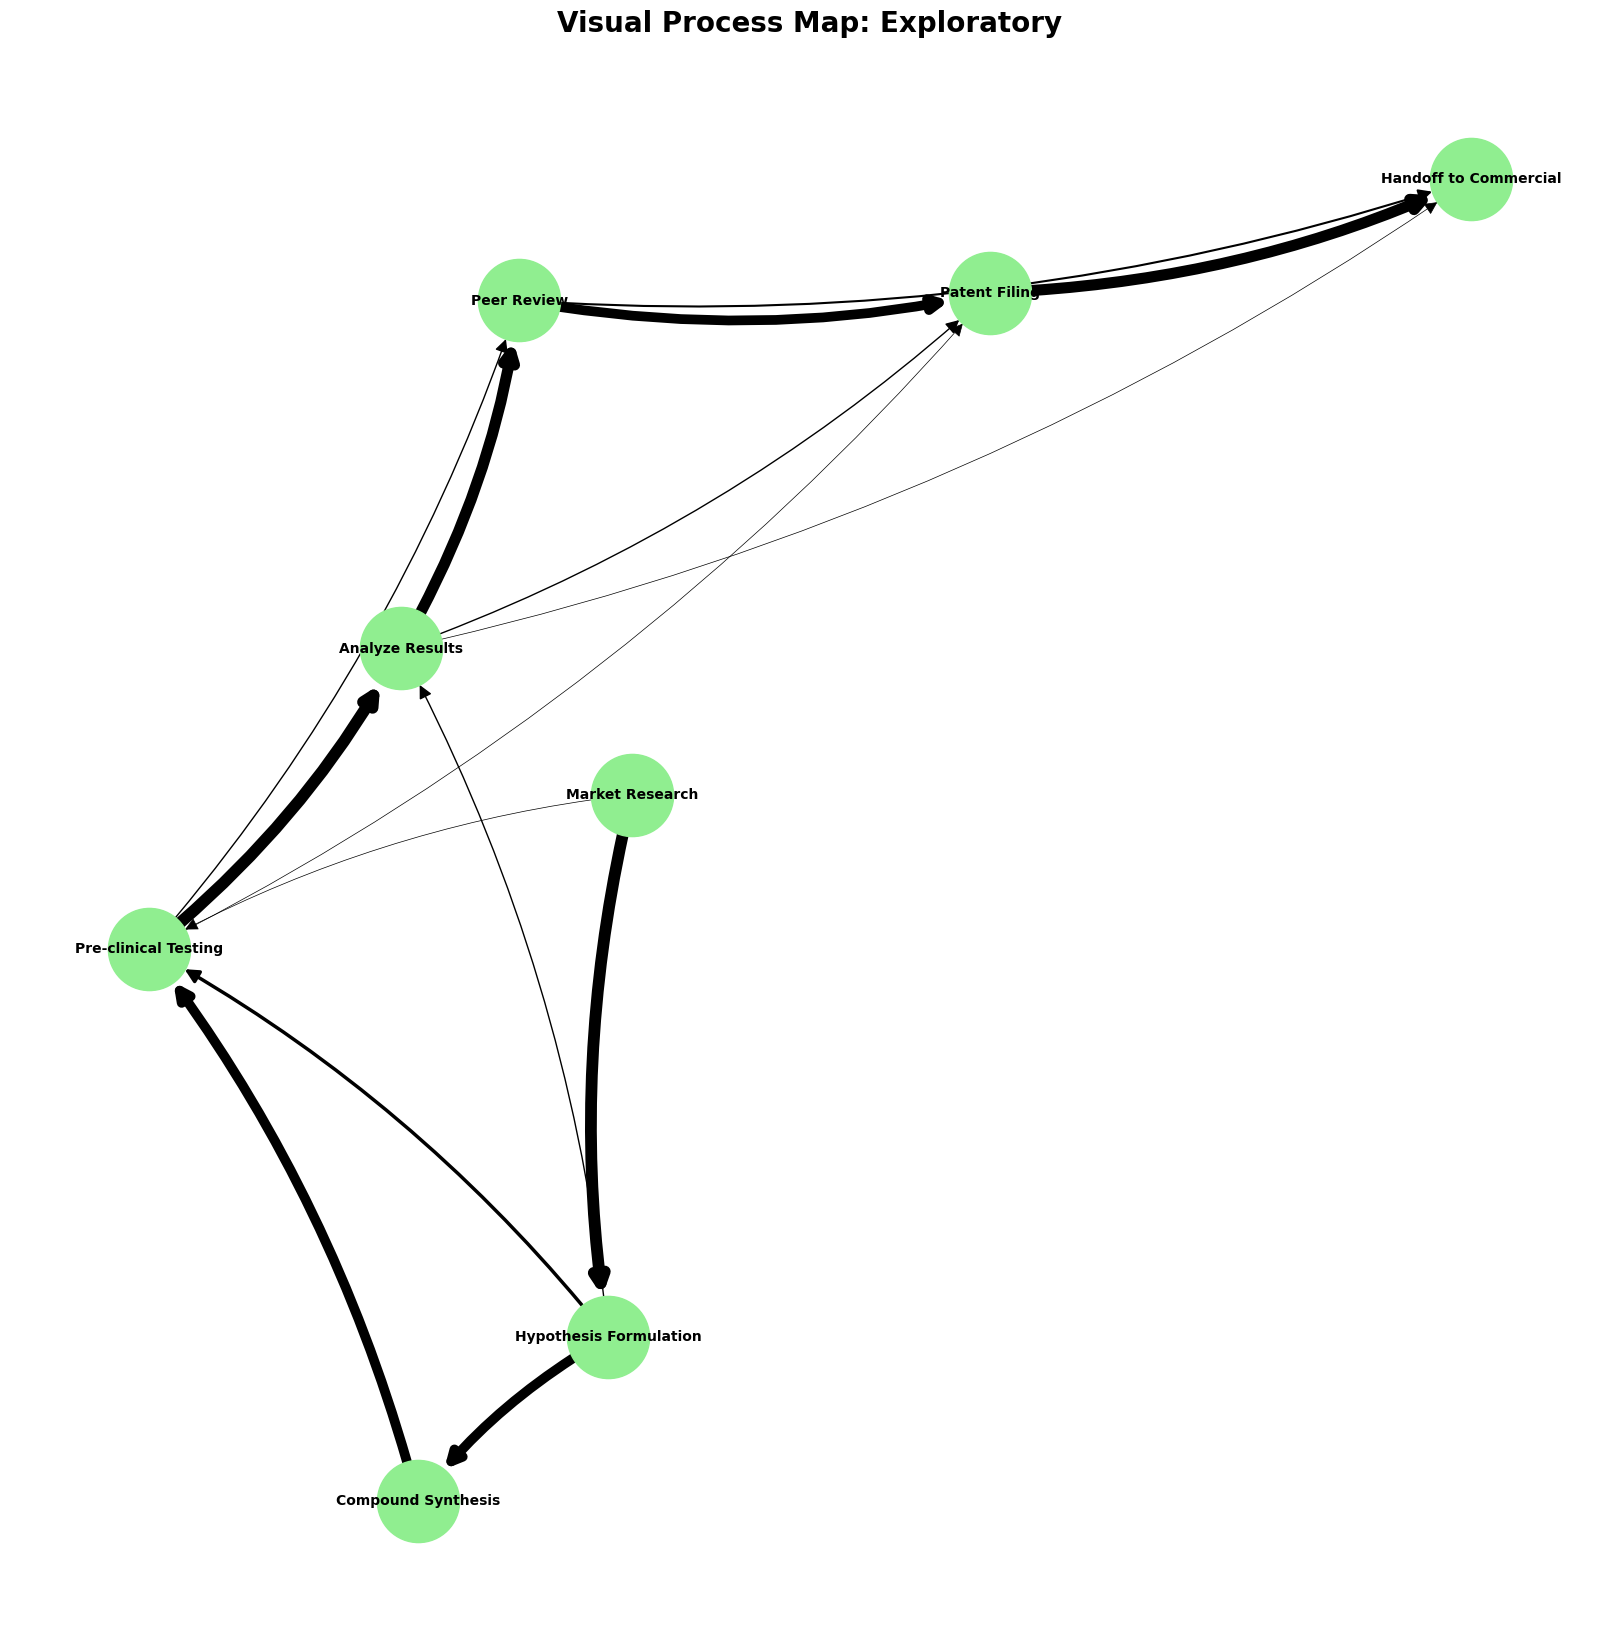

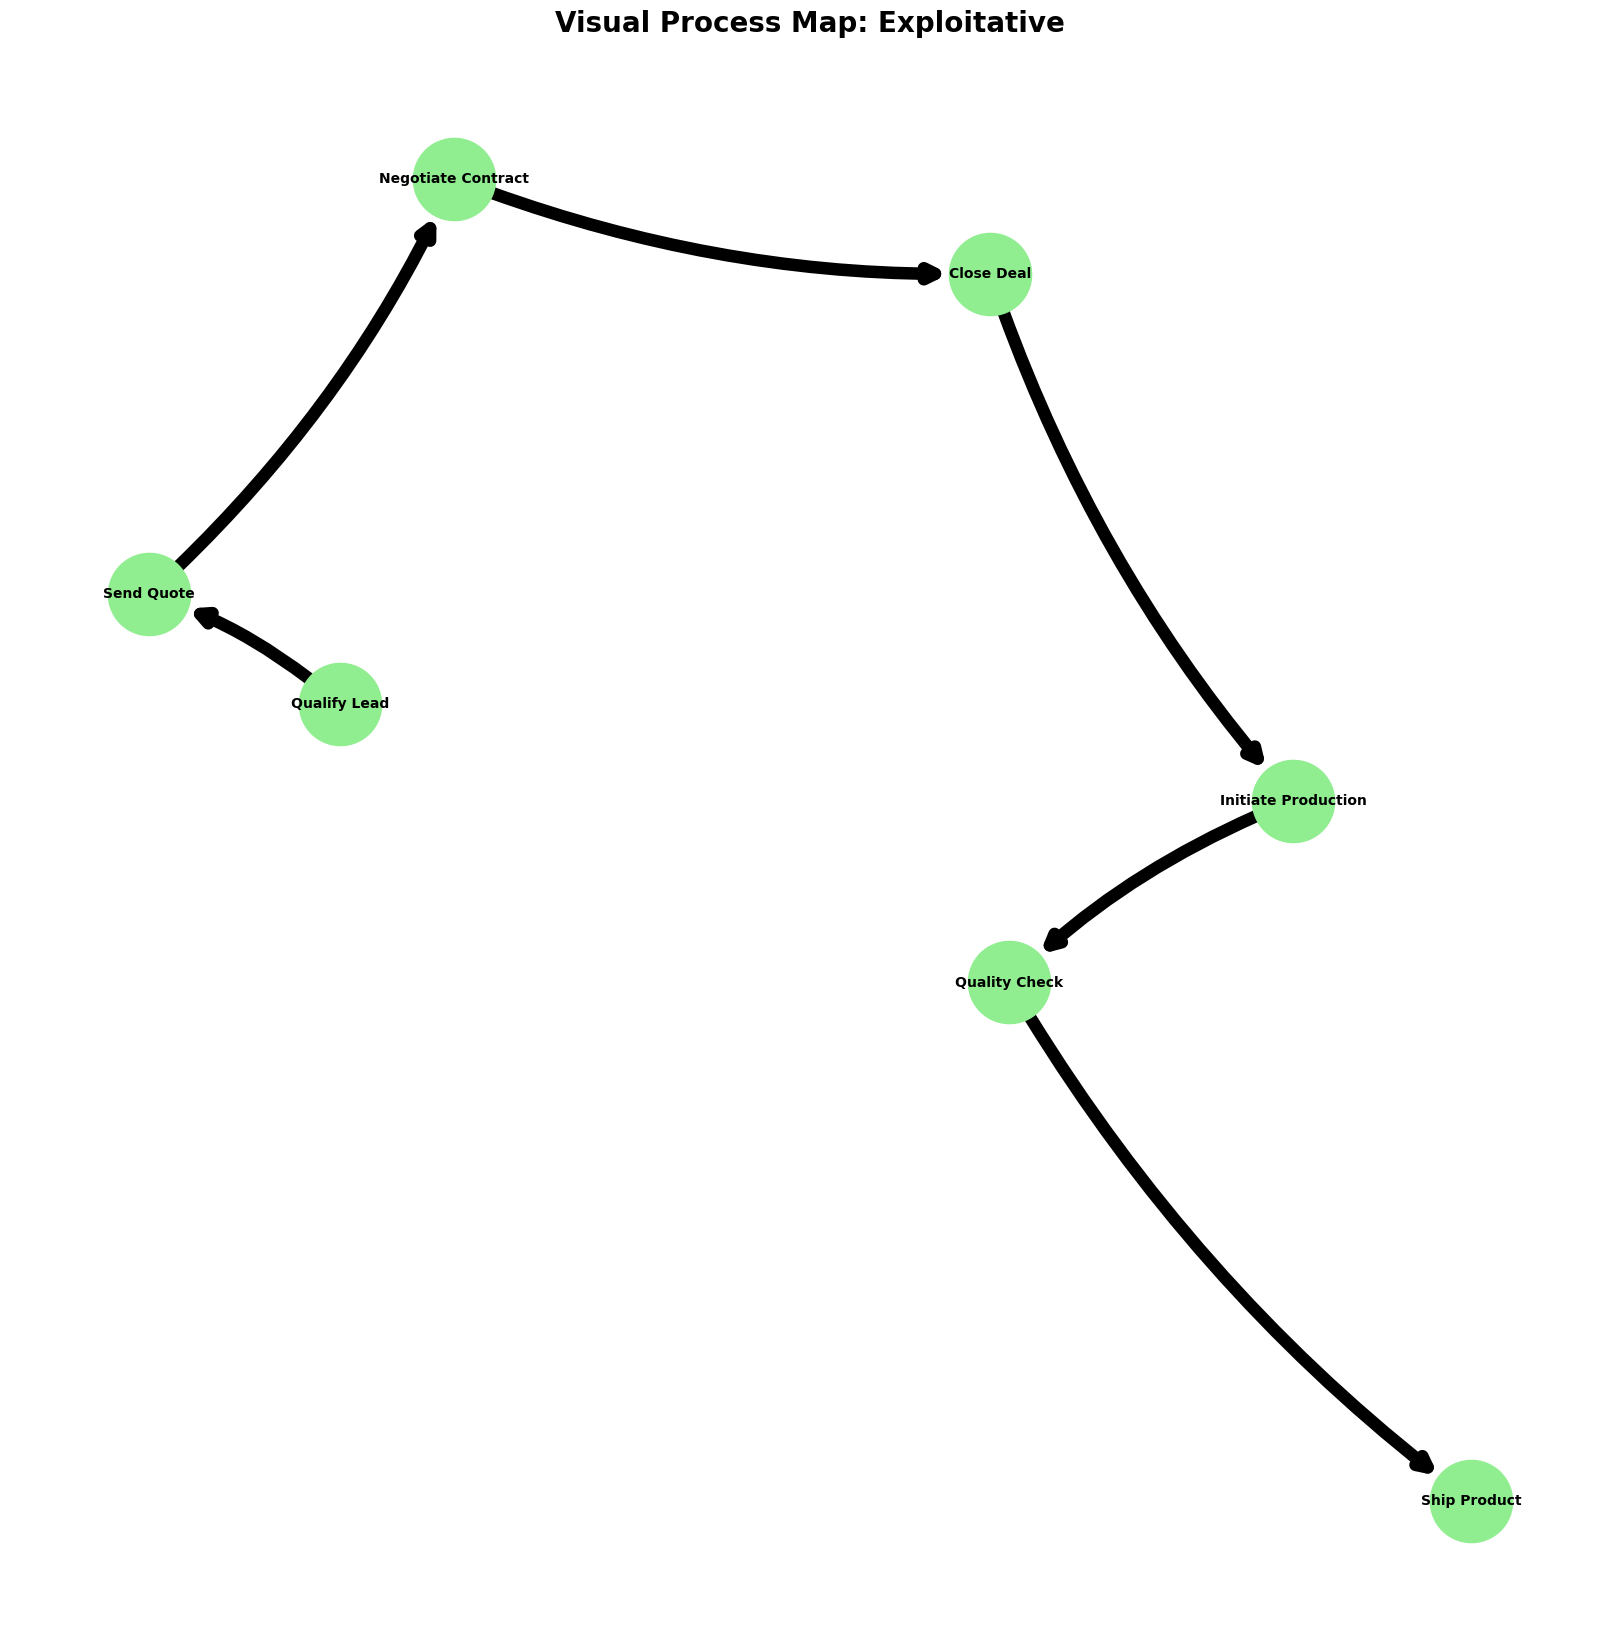

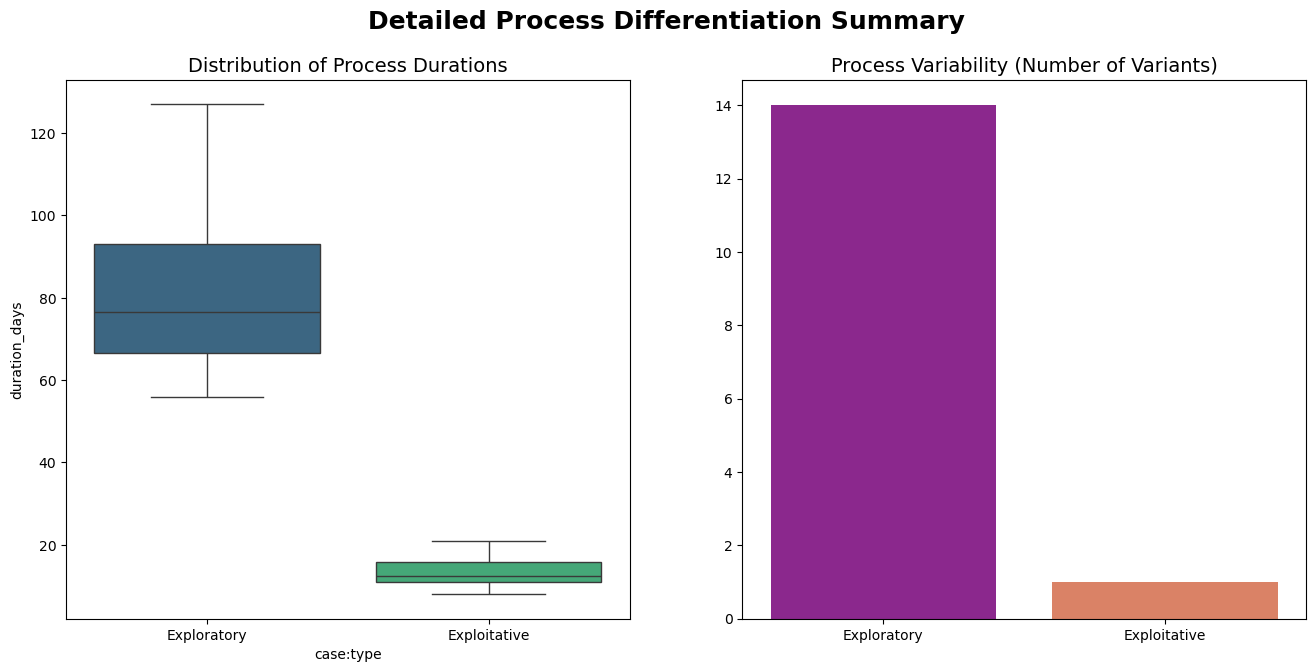

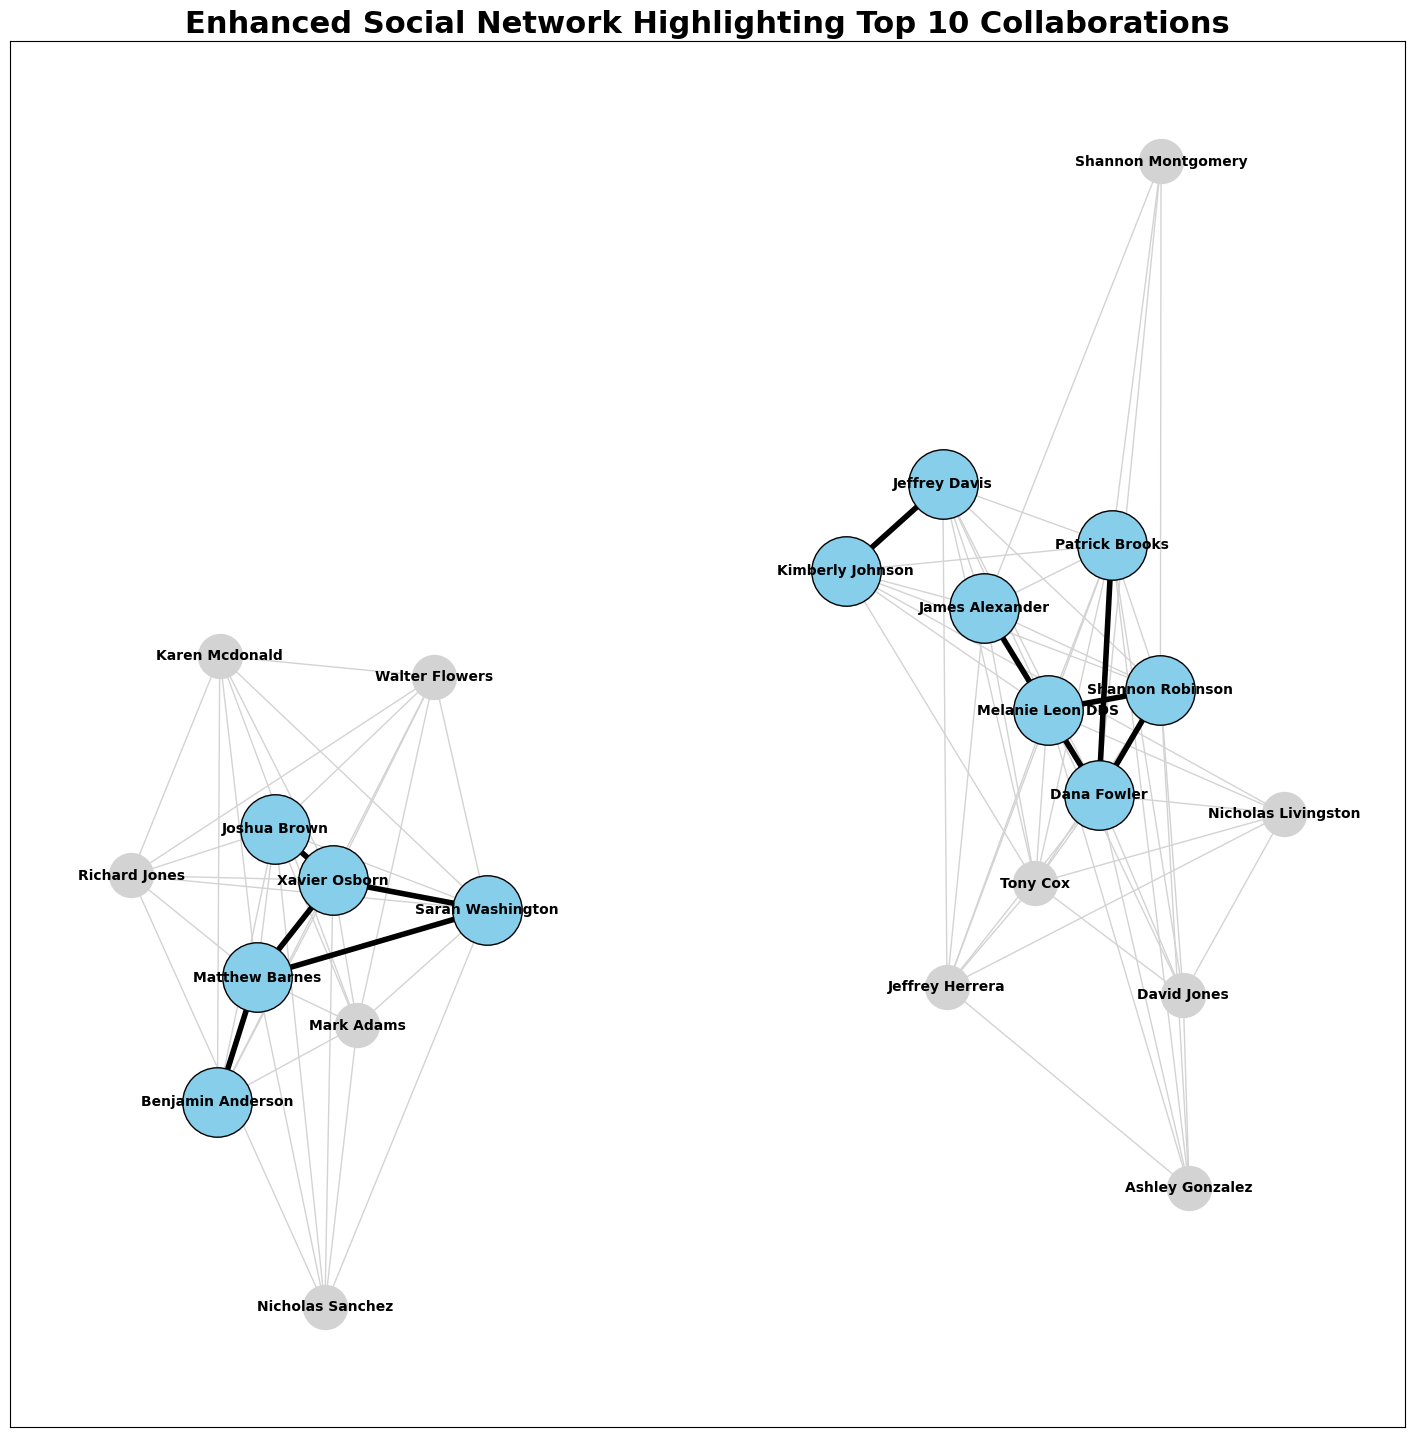

In [8]:
# --- MAIN EXECUTION ---
if __name__ == '__main__':
    event_log = simulate_event_log(num_cases=40)
    analyze_and_visualize_bottlenecks(event_log, 'Exploratory')
    analyze_and_visualize_bottlenecks(event_log, 'Exploitative')
    visualize_process_flow(event_log, 'Exploratory')
    visualize_process_flow(event_log, 'Exploitative')
    analyze_process_differentiation(event_log)
    analyze_process_integration(event_log)
    all_resources = event_log['org:resource'].unique()
    if len(all_resources) > 5:
        sample_team = np.random.choice(all_resources, size=5, replace=False).tolist()
        generate_manager_process_dashboard(event_log, fake.name(), sample_team)
    print("✅ Full Process Mining Analysis complete.")